In [43]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as md
from scipy.optimize import leastsq,curve_fit
import math
import time
import datetime as dt

In [3]:
def open_data(exp_id):
    ## basic paths
    data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
    analysis_local_path='D:/Analysis/' # D:\ is local SSD in the main experiment computer
    analysis_master_path='Y:/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\
    experiment_file='results.hdf5'
    qdp_name='qdp.txt'

    exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
    exp_path=data_master_path+exp_date+'/'+exp_id+'/'
    analysis_path=analysis_master_path+exp_date+'/'+exp_id+'/'

    if not os.path.exists(analysis_path):
        os.makedirs(analysis_path)

    if os.path.isfile(analysis_path+qdp_name):
        print "Yay! found old qdp class. We can save time!"
        q = qdp.load_qdp(filename=analysis_path+qdp_name)
    else:
        print "Coudn't find processed qdp. Loading and saving"
        q = qdp.QDP(base_data_path=exp_path)
        q.load_data_file(experiment_file)
        q.save_qdp(filename=analysis_path+qdp_name)
    return q

def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-(x-x0)**2)/(sigma**2)))+offset
    return res

# Set experiment(s) to analyze


In [64]:
#analysis_master_path='Y:/Rb/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\
exp_id='2018_03_05_00_49_43_Closed loop, Fxed tgap Ramsey, N=500'
q=open_data(exp_id)
cuts=[[450],[450],[450]]
for r in range(5):
    q.set_thresholds(cuts, roi=r)
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
retention = q.apply_thresholds(dataset=range(0,31))

Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_03_05/2018_03_05_00_49_43_Closed loop, Fxed tgap Ramsey, N=500/qdp.txt


In [73]:
e=0
timestamp=[]
for i in range(len(np.squeeze(retention['ivar']))):
    iter_timestamp=q.experiments[e]['iterations'][i]['timestamp_iteration']
    timestamp.append(iter_timestamp)
dates=[dt.datetime.fromtimestamp(ts) for ts in timestamp]
print dates
xfmt=md.DateFormatter('%H:%M')

[datetime.datetime(2018, 3, 5, 0, 49, 50, 402000), datetime.datetime(2018, 3, 5, 0, 52, 58, 591000), datetime.datetime(2018, 3, 5, 0, 56, 11, 360000), datetime.datetime(2018, 3, 5, 0, 59, 9, 434000), datetime.datetime(2018, 3, 5, 1, 2, 23, 349000), datetime.datetime(2018, 3, 5, 1, 23, 30, 658000), datetime.datetime(2018, 3, 5, 1, 40, 43, 710000), datetime.datetime(2018, 3, 5, 1, 44, 18, 186000), datetime.datetime(2018, 3, 5, 1, 47, 19, 167000), datetime.datetime(2018, 3, 5, 1, 50, 24, 976000), datetime.datetime(2018, 3, 5, 1, 53, 30, 843000), datetime.datetime(2018, 3, 5, 1, 56, 43, 267000), datetime.datetime(2018, 3, 5, 1, 59, 50, 821000), datetime.datetime(2018, 3, 5, 2, 2, 55, 477000), datetime.datetime(2018, 3, 5, 2, 6, 6, 587000), datetime.datetime(2018, 3, 5, 2, 9, 18, 557000), datetime.datetime(2018, 3, 5, 2, 12, 24, 931000), datetime.datetime(2018, 3, 5, 2, 15, 29, 439000), datetime.datetime(2018, 3, 5, 2, 18, 41, 192000), datetime.datetime(2018, 3, 5, 2, 21, 58, 636000), datet

<IPython.core.display.Javascript object>


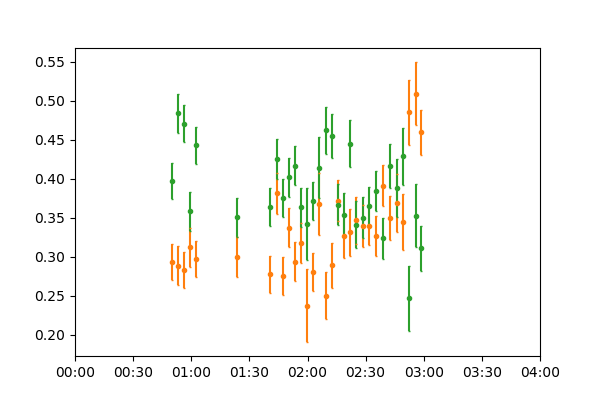

In [83]:
savefig=False
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
fit_guesses=[30,0.4,2,0,0.5]
roi_dependency=[0,0,0,0,0]
fitted_parameters=[]
for roi in [1,2]:
    data = []
    timedata=[]
    reten = []
    err = []
    for e in range(len(np.squeeze(retention['ivar']))):
        data.append(np.squeeze(retention['ivar'])[e][roi])
        reten.append(np.squeeze(retention['retention'])[e][roi])
        err.append(np.squeeze(retention['error'])[e][roi])
    ax.errorbar(dates,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',markersize=3,color=colors[roi],capsize=1)
    ax.xaxis.set_major_formatter(xfmt)
    datemin = dt.datetime(2018, 3, 5,0,0,0)
    datemax = dt.datetime(2018, 3, 5,4,0,0)
    ax.set_xlim(datemin, datemax)

# Camera plots, red

<IPython.core.display.Javascript object>


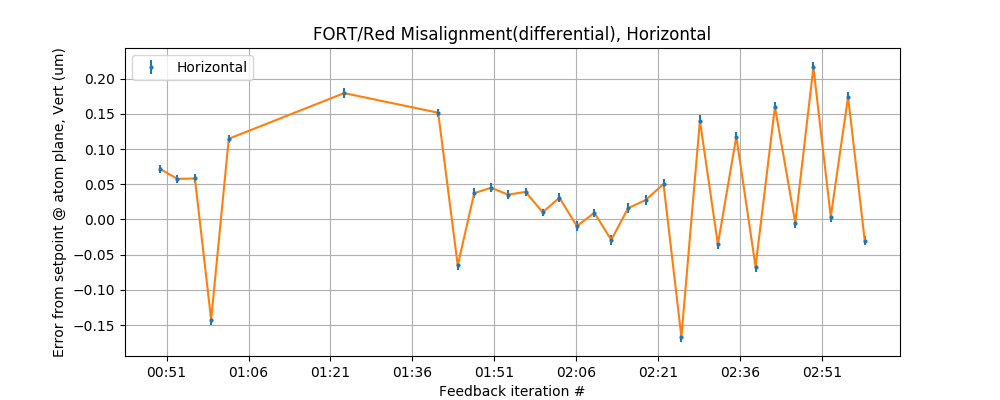

31
31


<IPython.core.display.Javascript object>


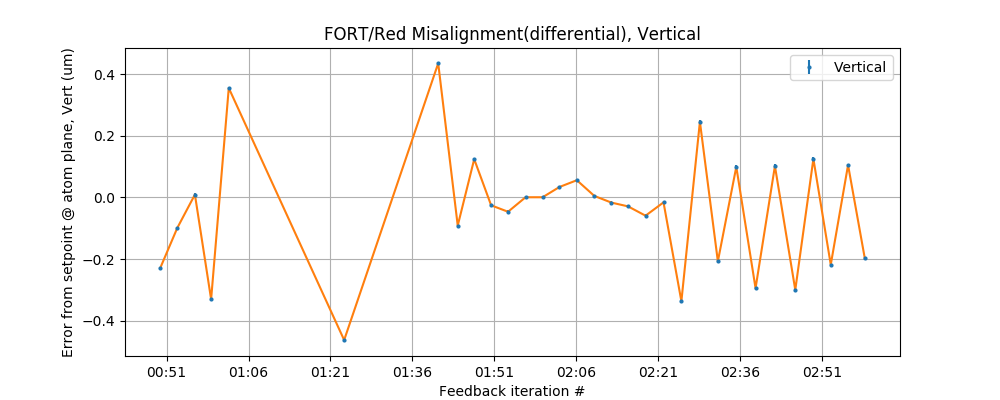

<IPython.core.display.Javascript object>


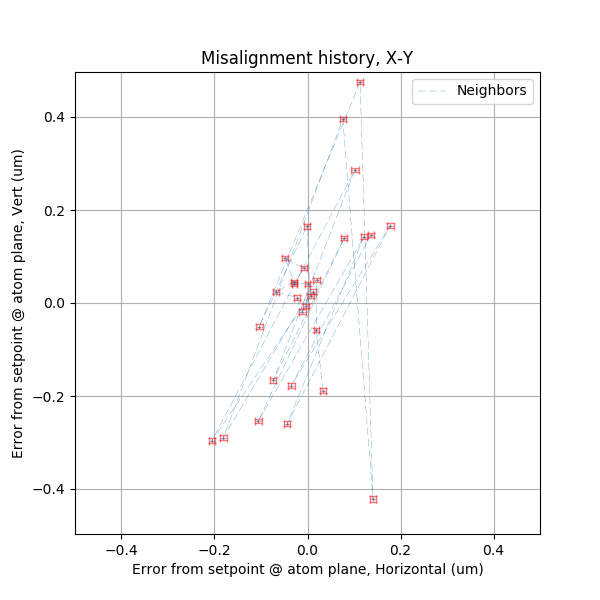

In [72]:
savefig=False
figW=10
figH=4
whichside='AAS_redside' #'AAS_
#whichside='AAS_redside'
fig, ax = plt.subplots()
fig.set_size_inches(figW,figH)
xdata = []
ydata = []
yerr = []
target=np.array([-101.742,-43.384])
sample_numbers=500
user_specified=31
iteration_range=range(min(len(np.squeeze(retention['ivar'])),user_specified))
for e in iteration_range:
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e][whichside]['x'])
    yerr.append(q.experiments[0]['iterations'][e][whichside]['sigma_x'])
print np.size(xdata)    
print np.size(ydata)
offset=target[0]#np.mean(ydata)
Xcoord=ydata-offset
Xcoord_err=yerr
ax.errorbar(dates,Xcoord,yerr=np.array(yerr)/(np.sqrt(sample_numbers)),fmt='o',markersize=2,label='Horizontal')
ax.plot(dates,Xcoord)
ax.xaxis.set_major_formatter(xfmt)

plt.show()
#ax.set_title(exp_id)
ax.set_title('FORT/Red Misalignment(differential), Horizontal')
#ax.set_xlim(0,130)
#ax.set_ylim(-10, 10)
ax.set_xlabel(xlab)
ax.set_ylabel('Error from setpoint @ atom plane, Vert (um)')
ax.grid()
ax.legend()
ax.set_xlabel('Feedback iteration #')
if savefig:
    fig.savefig(exp_id+'Camera_X.pdf')
    fig.savefig(exp_id+'Camera_X.png')

fig, ax = plt.subplots()
fig.set_size_inches(figW,figH)
xdata = []
ydata = []
yerr = []
iteration_range=range(min(len(np.squeeze(retention['ivar'])),user_specified))
for e in iteration_range:
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e][whichside]['y'])
    yerr.append(q.experiments[0]['iterations'][e][whichside]['sigma_y'])
offset=target[1]
Ycoord=ydata-offset
Ycoord_err=yerr
ax.set_title('FORT/Red Misalignment(differential), Vertical')
ax.errorbar(dates,Ycoord,yerr=np.array(yerr)/(np.sqrt(sample_numbers)),fmt='o',markersize=2,label='Vertical')
ax.plot(dates,Ycoord)
ax.xaxis.set_major_formatter(xfmt)
#ax.set_title(exp_id)
#ax.set_xlim(0,130)
#ax.set_ylim(11.6, 13)
ax.set_xlabel(xlab)
ax.set_ylabel('Error from setpoint @ atom plane, Vert (um)')
ax.grid()
ax.legend()
ax.set_xlabel('Feedback iteration #')
if savefig:
    fig.savefig(exp_id+'Camera_Y.pdf')
    fig.savefig(exp_id+'Camera_Y.png')

fig, ax = plt.subplots()
fig.set_size_inches(6,6)
length_conversion=1.0 # Red gives already in um units
cutoff=-1
xdata=length_conversion*(Xcoord[0:cutoff]-np.nanmean(Xcoord))
xerr=length_conversion*np.array(Xcoord_err[0:cutoff])/math.sqrt(sample_numbers)
ydata=length_conversion*(Ycoord[0:cutoff]-np.nanmean(Ycoord))
yerr=length_conversion*np.array(Ycoord_err[0:cutoff])/math.sqrt(sample_numbers)
ax.errorbar(xdata,ydata,xerr=xerr,yerr=yerr,fmt='o',ecolor='red',elinewidth=0.5,markersize=1,capsize=3,alpha=0.5)
ax.plot(xdata,ydata,'--',linewidth=0.2,label='Neighbors')

ax.set_title('Misalignment history, X-Y')
ax.set_xlim(-0.5,0.5)
ax.set_ylim(-0.5,0.5)
ax.set_xlabel('Error from setpoint @ atom plane, Horizontal (um)')
ax.set_ylabel('Error from setpoint @ atom plane, Vert (um)')
ax.set_aspect('equal', 'datalim')
ax.grid()
ax.legend()
if savefig:
    fig.savefig(exp_id+'Camera Beam history.pdf')
    fig.savefig(exp_id+'Camera Beam history.png')

In [77]:
q.experiments[0]['iterations'][0]

{'AAS_blueside': {},
 'AAS_redside': {'ctrl_x': -0.10053049778375971,
  'ctrl_y': -0.59898671295941097,
  'error_x': -0.36295879694336008,
  'error_y': -1.7033885760300223,
  'sigma_x': 0.05667258028647764,
  'sigma_y': 0.056232172550881178,
  'x': -101.07024656641195,
  'y': -45.368050951997496},
 'FORT_camera_dataX': 224.26534271505133,
 'FORT_camera_dataY': 48.81424368500582,
 'Red_camera_dataX': 325.33077444646483,
 'Red_camera_dataY': 94.197098932998756,
 'loaded': array([ 0.,  0.,  0.,  0.,  0.]),
 'loading': array([ 0.,  0.,  0.,  0.,  0.]),
 'quantized_data': array([[[ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.]],
 
        ..., 
        [[ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
        

# Actuator plot

<IPython.core.display.Javascript object>


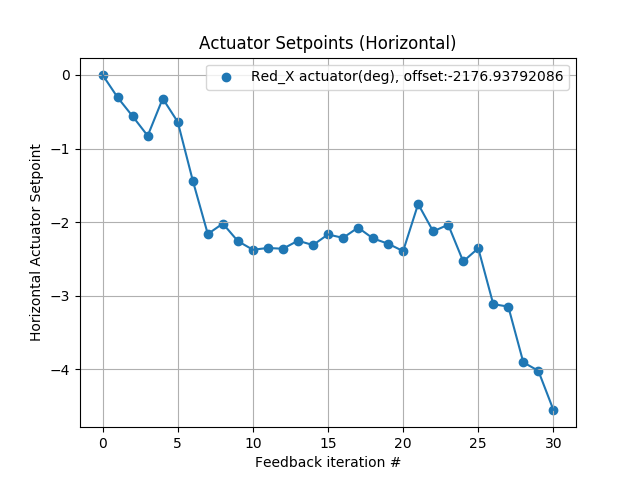

<IPython.core.display.Javascript object>


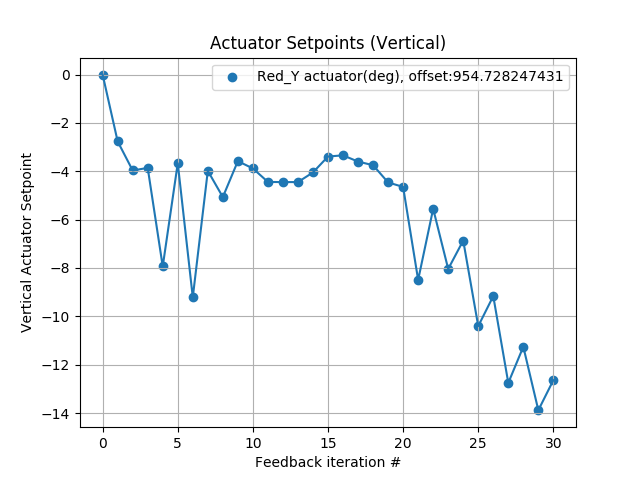

<IPython.core.display.Javascript object>


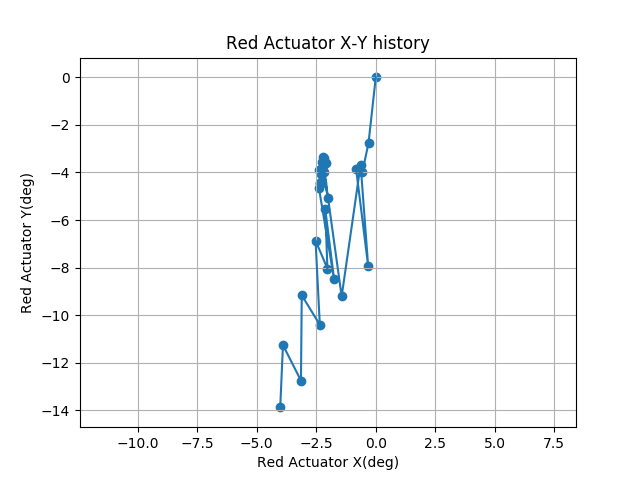

In [16]:
## X actuator plot
fig, ax = plt.subplots()
xdata = []
ydata = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e]['variables']['Red_X'])
offset=ydata[0]#np.median(ydata)
Xactuator=ydata-offset
ax.scatter(xdata,Xactuator,label='Red_X actuator(deg), offset:{}'.format(offset))
ax.plot(xdata,Xactuator)
#ax.set_title(exp_id)
ax.set_title('Actuator Setpoints (Horizontal)')
#ax.set_xlim(0,130)
#ax.set_ylim(-10, 10)
ax.set_xlabel('Feedback iteration #')
ax.set_ylabel('Horizontal Actuator Setpoint')
ax.grid()
ax.legend()
plt.show()
if savefig:
    fig.savefig(exp_id+'actuatorX.pdf')
    fig.savefig(exp_id+'actuatorX.png')

## Y actuator plot
fig, ax = plt.subplots()
xdata = []
ydata = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e]['variables']['Red_Y'])
offset=ydata[0]
Yactuator=ydata-offset
ax.scatter(xdata,Yactuator,label='Red_Y actuator(deg), offset:{}'.format(offset))
ax.plot(xdata,Yactuator)


#ax.set_title(exp_id)
ax.set_title('Actuator Setpoints (Vertical)')
#ax.set_xlim(0,130)
#ax.set_ylim(11.6, 13)
ax.set_xlabel('Feedback iteration #')
ax.set_ylabel('Vertical Actuator Setpoint')
ax.grid()
ax.legend()
if savefig:
    fig.savefig(exp_id+'actuatorY.pdf')
    fig.savefig(exp_id+'actuatorY.png')
##
fig, ax = plt.subplots()
length_conversion=1.0 # Red gives already in um units
cutoff=-1
xdata=Xactuator[0:cutoff]
ydata=Yactuator[0:cutoff]
ax.plot(xdata,ydata)
ax.scatter(xdata,ydata)
ax.set_title('Red Actuator X-Y history')
#ax.set_xlim(-1,1)
#ax.set_ylim(-1, 1)
ax.set_xlabel('Red Actuator X(deg)')
ax.set_ylabel('Red Actuator Y(deg)')
ax.set_aspect('equal', 'datalim')
ax.grid()
ax.legend()
if savefig:
    fig.savefig(exp_id+'actuatorXY.pdf')
    fig.savefig(exp_id+'actuatorXY.png')

<IPython.core.display.Javascript object>


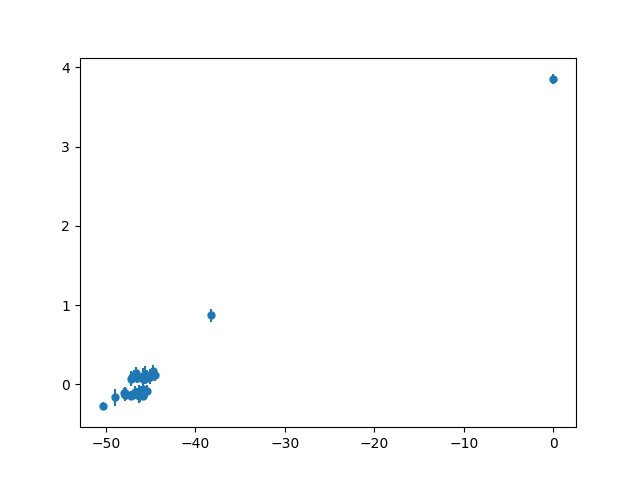

<IPython.core.display.Javascript object>


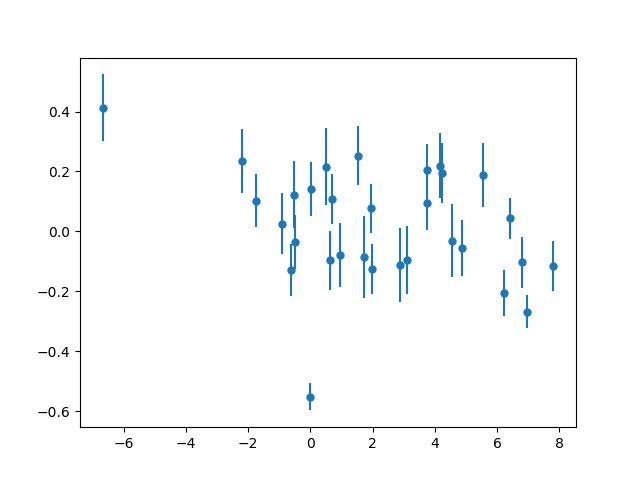

<Container object of 3 artists>

In [67]:
fig, ax = plt.subplots()
ax.errorbar(Xactuator,Xcoord,yerr=Xcoord_err,fmt='o',markersize=5)
fig, ax = plt.subplots()
ax.errorbar(Yactuator,Ycoord,yerr=Ycoord_err,fmt='o',markersize=5)

<IPython.core.display.Javascript object>

AttributeError: Unknown property fmt

<IPython.core.display.Javascript object>


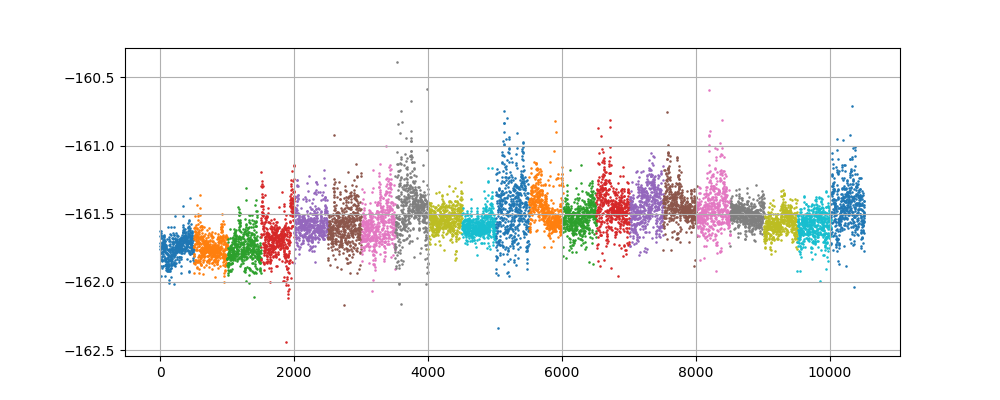

In [91]:
fig, ax = plt.subplots()
fig.set_size_inches(10,4)
for e in range(len(np.squeeze(retention['ivar']))):
    data1=np.array(q.experiments[0]['iterations'][e]['FORT_camera_dataX'])
    data2=np.array(q.experiments[0]['iterations'][e]['Red_camera_dataX'])
    x=np.array(range(0,np.size(data1)))
    ax.scatter(x+np.size(data1)*e,data1-data2,s=0.7) #in microns

#ax.set_title(exp_id)
#ax.set_title('Actuator Setpoints (Horizontal)')
#ax.set_xlim(5500,6700)
#ax.set_ylim(-10, 10)
#ax.set_xlabel('Feedback iteration #')
#ax.set_ylabel('Horizontal Actuator Setpoint')
ax.grid()
ax.legend()
plt.show()


<IPython.core.display.Javascript object>


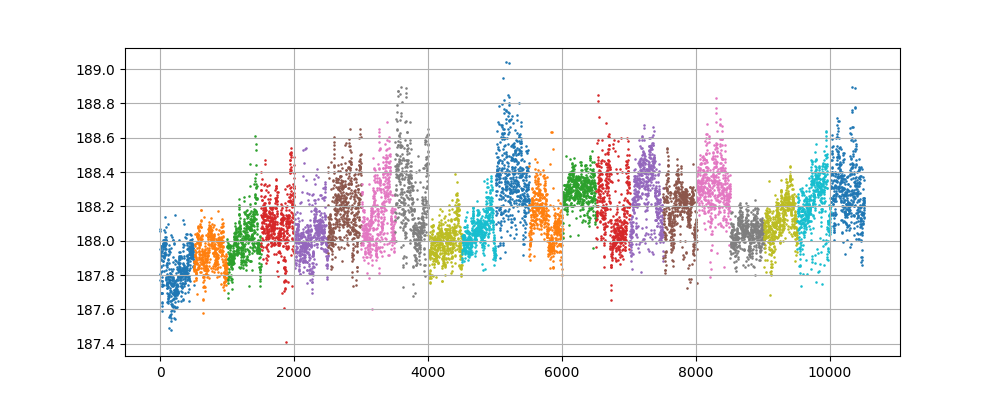

<IPython.core.display.Javascript object>


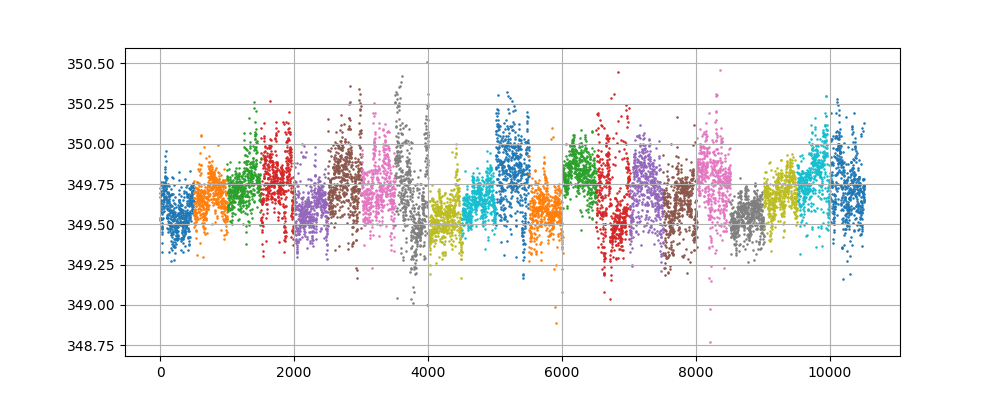

In [92]:
fig, ax = plt.subplots()
fig.set_size_inches(10,4)
for e in range(len(np.squeeze(retention['ivar']))):
    data1=np.array(q.experiments[0]['iterations'][e]['FORT_camera_dataX'])
    x=np.array(range(0,np.size(data1)))
    ax.scatter(x+np.size(data1)*e,data1,s=0.7) #in microns

#ax.set_title(exp_id)
#ax.set_title('Actuator Setpoints (Horizontal)')
#ax.set_xlim(0,130)
#ax.set_ylim(-10, 10)
#ax.set_xlabel('Feedback iteration #')
#ax.set_ylabel('Horizontal Actuator Setpoint')
#ax.set_xlim(5000,6000)
ax.grid()
ax.legend()
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(10,4)
for e in range(len(np.squeeze(retention['ivar']))):
    #data1=np.array(q.experiments[0]['iterations'][e]['FORT_camera_dataX'])
    data2=np.array(q.experiments[0]['iterations'][e]['Red_camera_dataX'])
    x=np.array(range(0,np.size(data2)))
    ax.scatter(x+np.size(data2)*e,data2,s=0.7) #in microns


#ax.set_title(exp_id)
#ax.set_title('Actuator Setpoints (Horizontal)')
#ax.set_xlim(0,2000)
#ax.set_ylim(-10, 10)
#ax.set_xlabel('Feedback iteration #')
#ax.set_ylabel('Horizontal Actuator Setpoint')
#ax.set_xlim(5000,6000)
ax.grid()
ax.legend()
plt.show()

In [74]:
len(np.squeeze(retention['ivar']))

301